# ДЗ №11 Fraud detection with clusterization
Добавлено: 30.10.2021 15:34
Сдать до 24 января 17:00


* Будем использовать датасет и задачу из прошлого домашнего задания. 
* Перед вами стоит задача по информации о банковской транзакции определить мошенническая она или нет. 
* В архиве будут 2 csv файла, нужно попытаться использовать оба для предсказаний.
* Целевую колонку (isFraud) в файле trans_small.csv перед построением кластеров необходимо удалить.

Задание:
* Использовать предобработку датасета из прошлого домашнего задания
* Кластеризовать данные при помощи KMeans
* Найти оптимальное количество кластеров
* Посчитать Silhouette index
* Кластеризовать данные при помощи DBSCAN
* Проанализировать средние значения признаков в кластерах, что вы можете о них сказать?
* Сравнить принадлежность конкретной записи к кластеру и удалённую целевую колонку isFraud.
* Сравните по метрике AUC какой подход лучше - из прошлой работы, или из этой (supervised vs unsupervised)

Опционально:
* Можно ли визуализировать полученные кластеры? 
* (Подсказка: возможно нужно использовать методы понижения размерности, или уже готовые библиотеки)

# Import section

In [40]:
# Base library
import numpy as np                                        # Linear algebra
import pandas as pd                                       # Data processing

# Visualization library
import matplotlib.pyplot as plt                           # Plotting library 
import seaborn as sns                                     # Data visualization

# Displays output inline
%matplotlib inline     

# Machine learning library
from sklearn.linear_model import LogisticRegression       # Class implements regularized logistic regression
from sklearn.model_selection import train_test_split      # Split arrays
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import silhouette_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import class_weight


from sklearn.cluster import KMeans # Import KMeans from SciKit Learn.
from sklearn.cluster import DBSCAN # Import DBSCAN from SciKit Learn.

# Data section

## Load the data

In [41]:
# Оставим только основные шаги по обработке дата сета с 10 работы

# Read csv file as a DataFrame.
data1 = pd.read_csv("identity_small.csv")
data2 = pd.read_csv("trans_small.csv")

## Exploratory data analysis and visualization

In [42]:
# Data dimensionality
print(f"Shape data1: \n{data1.shape}")
# Data dimensionality
print(f"Shape data2: \n{data2.shape}")

Shape data1: 
(144233, 8)
Shape data2: 
(590540, 23)


In [43]:
# data1 является дополнение набора data2 по 144233 строкам. Объединим оба набора в один.
data = pd.merge(data1, data2, on='TransactionID', how='outer')

# Preview the data
# Title DataFrame diabetes (return the first `n` rows) 
data.head(n=3)

,TransactionID,id_04,id_20,id_24,id_33,id_29,id_22,id_02,D4,card1,...,V225,V277,V243,V40,V46,V244,V274,V73,V147,M5
0,2987004,NaN,144.0,NaN,2220x1080,NotFound,NaN,70787.0,NaN,4497,...,0.0,0.000000,1.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
1,2987008,NaN,500.0,NaN,1334x750,NotFound,NaN,98945.0,NaN,2803,...,0.0,0.000000,1.0,NaN,NaN,1.0,0.0,NaN,0.0,NaN
2,2987010,0.0,142.0,NaN,NaN,Found,NaN,191631.0,0.0,16496,...,2.0,75.887497,1.0,1.0,2.0,1.0,0.0,2.0,NaN,NaN


In [44]:
# Print a concise summary of a DataFrame.
print(data.info(), '\n')

# Column names
print(f"Column names: \n{data.columns}", '\n')

# Data dimensionality
print(f"Shape: \n{data.shape}", '\n')

# Data types for each attribute
#print(f"Data types: \n{data.dtypes}", '\n')

# Detect missing values.
#print(f"Missing values by attribute: \n{data.isnull().sum()}", '\n')

# Descriptive Statistics:
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   id_04           66324 non-null   float64
 2   id_20           139261 non-null  float64
 3   id_24           4747 non-null    float64
 4   id_33           73289 non-null   object 
 5   id_29           140978 non-null  object 
 6   id_22           5169 non-null    float64
 7   id_02           140872 non-null  float64
 8   D4              421618 non-null  float64
 9   card1           590540 non-null  int64  
 10  card2           581607 non-null  float64
 11  card3           588975 non-null  float64
 12  addr1           524834 non-null  float64
 13  addr2           524834 non-null  float64
 14  TransactionAmt  590540 non-null  float64
 15  isFraud         590540 non-null  int64  
 16  C13             590540 non-null  float64
 17  D10       

,TransactionID,id_04,id_20,id_24,id_22,id_02,D4,card1,card2,card3,...,D4.1,V225,V277,V243,V40,V46,V244,V274,V73,V147
count,5.905400e+05,66324.000000,139261.000000,4747.000000,5169.000000,140872.000000,421618.000000,590540.000000,581607.000000,588975.000000,...,421618.000000,130430.000000,130430.000000,130430.000000,421571.000000,421571.000000,130430.000000,130430.000000,513444.000000,81945.000000
mean,3.282270e+06,-0.058938,403.882666,12.800927,16.002708,174716.584708,140.002441,9898.734658,362.555488,153.194925,...,140.002441,0.191758,51.956645,1.178387,0.177145,1.022286,1.118562,107.151636,0.139982,0.168601
std,1.704744e+05,0.701015,152.160327,2.372447,6.897665,159651.816856,191.096774,4901.170153,157.793246,11.336444,...,191.096774,1.290820,732.145368,1.398953,0.505786,0.166719,0.698807,1258.734139,0.367098,0.750497
min,2.987000e+06,-28.000000,100.000000,11.000000,10.000000,1.000000,-122.000000,1000.000000,100.000000,100.000000,...,-122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,256.000000,11.000000,14.000000,67992.000000,0.000000,6019.000000,214.000000,150.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,472.000000,11.000000,14.000000,125800.500000,26.000000,9678.000000,361.000000,150.000000,...,26.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,533.000000,15.000000,14.000000,228749.000000,253.000000,14184.000000,512.000000,150.000000,...,253.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,3.577539e+06,0.000000,661.000000,26.000000,44.000000,999595.000000,869.000000,18396.000000,600.000000,231.000000,...,869.000000,51.000000,104060.000000,57.000000,24.000000,6.000000,22.000000,66000.000000,7.000000,26.000000


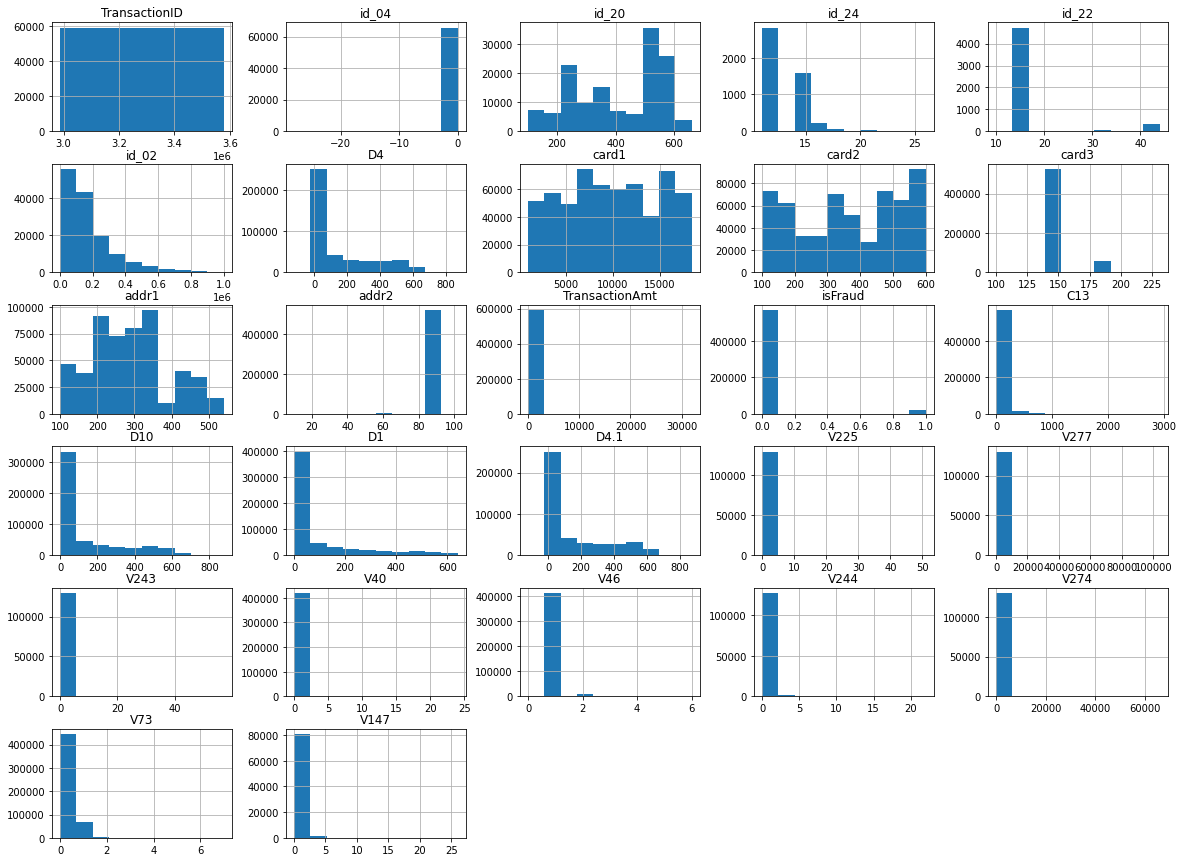

In [45]:
# Dataframe visualization
# Построим дополнительно -histogram, -pairplot для лучшего понимания структуры данных (как между собой разделяются классы). 
 
# Plot histogram
data.hist(figsize=(20,15));

In [46]:
# Построим матрицу корреляции между признаками на исходных данных:

# Весь набор данных
plt.figure(figsize=(20,15))
#data.corr()
#sns.heatmap(data.corr(),annot=True, cmap="coolwarm");

<Figure size 1440x1080 with 0 Axes>

<Figure size 1440x1080 with 0 Axes>

0    569877
1     20663
Name: isFraud, dtype: int64 



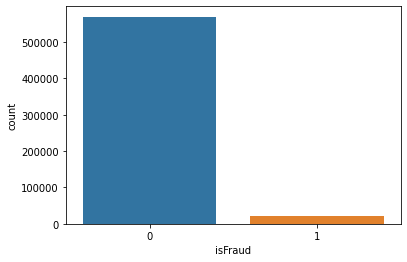

In [47]:
# Рассмотрим целевую/target переменную - 'Class'.

# Distribution of data by class, text
print(data['isFraud'].value_counts(), '\n')
# Distribution of data by class, graphic
sns.countplot(data=data, x='isFraud');

Summary of dataset:

* общее количество колонок - 30 (29 атрибутов и одна целевая переменная)
* количество сэмплов/строк – 590540
* пропущенных значении - значительное количество пропущенных значении
* все признаки - являются числовыми значениями
* целевая переменная - 'isFraud' содержит два класса: class 0 - 569877(96.5%) и class 1 - 20663(3.5%)  (Присутствует большой дисбаланс классов.)

## Categorical Data

In [48]:
# Категориальными данными являются три атрибута "id_33", "id_29", "M5" (data.dtypes)
data[["id_33", "id_29", "M5"]].head(3)

,id_33,id_29,M5
0,2220x1080,NotFound,NaN
1,1334x750,NotFound,NaN
2,NaN,Found,NaN


In [49]:
# Distribution of data
#print(data['id_33'].value_counts(), '\n')

# Атрибут 'id_33' - является разрешение экрана устройств с которых подключались к сети банка, 260 уникальных значений. Удалим из набора.
data.drop('id_33', axis=1, inplace=True)

In [50]:
# Distribution of data
print(data['id_29'].value_counts(), '\n')

Found       74926
NotFound    66052
Name: id_29, dtype: int64 



In [51]:
# Distribution of data
print(data['M5'].value_counts(), '\n')

F    132491
T    107567
Name: M5, dtype: int64 



In [52]:
# Атрибут 'id_29' и 'M5' имеют по два уникальных значения (категориальные бинарные)

# Convert categorical variable into dummy/indicator variables
# drop_first=True -> Multicollinearity except
# Для категориальных бинарных значении параметр drop_first=True, иначе drop_first=False

data['id_29'] = pd.get_dummies(data["id_29"], drop_first=True)
data['M5'] = pd.get_dummies(data["M5"], drop_first=True)

In [120]:
# Data types for each attribute. Теперь все данные в наборе числовые.
#print(f"Data types: \n{data.dtypes}")

## Missing values

In [54]:
# Detect missing values.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID      0.000000
id_04             88.768923
id_20             76.418024
id_24             99.196159
id_29              0.000000
id_22             99.124699
id_02             76.145223
D4                28.604667
card1              0.000000
card2              1.512683
card3              0.265012
addr1             11.126427
addr2             11.126427
TransactionAmt     0.000000
isFraud            0.000000
C13                0.000000
D10               12.873302
D1                 0.214888
D4.1              28.604667
V225              77.913435
V277              77.913435
V243              77.913435
V40               28.612626
V46               28.612626
V244              77.913435
V274              77.913435
V73               13.055170
V147              86.123717
M5                 0.000000
dtype: float64 %


In [55]:
# Атрибуты ['id_04', 'id_20', 'id_24', 'id_22', 'id_02', 'D4', 'D10', 'V225', 'V277', 'V243', 'V244', 'V274', 'V73', 'V147'] 
# имеют больше половины пропущенных значений, удалим. Также удалим 'D4' повтотряет 'D4.1'.
data.drop(['id_04', 'id_20', 'id_24', 'id_22', 'id_02', 'D4', 'D10', 'V225', 'V277', 'V243', 'V244', 'V274', 'V73', 'V147'], axis=1, inplace=True)

In [56]:
data.columns

Index(['TransactionID', 'id_29', 'card1', 'card2', 'card3', 'addr1', 'addr2',
       'TransactionAmt', 'isFraud', 'C13', 'D1', 'D4.1', 'V40', 'V46', 'M5'],
      dtype='object')

In [57]:
# Detect missing values. Проверим повторно оствшиеся атрибуты. Заполним пропущенные значения медианой.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID      0.000000
id_29              0.000000
card1              0.000000
card2              1.512683
card3              0.265012
addr1             11.126427
addr2             11.126427
TransactionAmt     0.000000
isFraud            0.000000
C13                0.000000
D1                 0.214888
D4.1              28.604667
V40               28.612626
V46               28.612626
M5                 0.000000
dtype: float64 %


In [58]:
#Заполним пропущенные значения медианой. ['TransactionID', 'id_29', 'card1', 'card2', 'card3', 'addr1', 'addr2','TransactionAmt', 'isFraud', 'C13', 'D1', 'D4.1', 'V40', 'V46', 'M5']
data.fillna(data.mean(), inplace=True)

In [59]:
# Detect missing values. Проверим повторно оствшиеся атрибуты.
print(f"Missing values by attribute: \n{(100/590540)*data.isnull().sum()} %")

Missing values by attribute: 
TransactionID     0.0
id_29             0.0
card1             0.0
card2             0.0
card3             0.0
addr1             0.0
addr2             0.0
TransactionAmt    0.0
isFraud           0.0
C13               0.0
D1                0.0
D4.1              0.0
V40               0.0
V46               0.0
M5                0.0
dtype: float64 %


In [60]:
#Note: Все данные являются числовыми, все пропуски заплнены, форма набора:
# Data dimensionality
print(f"Shape: \n{data.shape}")

Shape: 
(590540, 15)


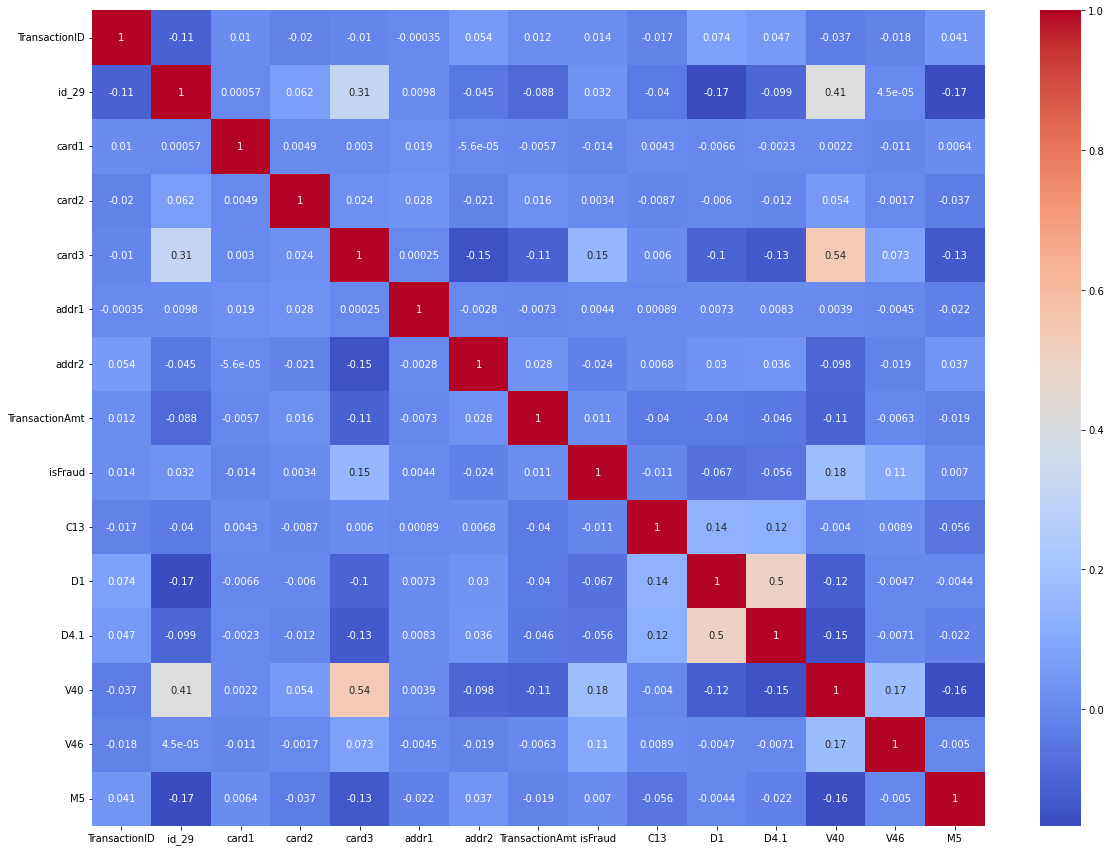

In [61]:
# Построим матрицу корреляции между признаками на обработанных данных:

# Весь набор данных
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(),annot=True, cmap="coolwarm");

## Train Test Split + PCA

In [83]:
# inputs / Массив X, содержит признаки для обучения
X = data.drop("isFraud", axis=1)

# outputs / Массив у с целевой переменной
y = data["isFraud"]

# Создадим дата фрейм с целевой переменной, в дальнейшем добавим предсказанные значения с кластеризации. 
targets = pd.DataFrame(data=y.values, columns=["original"])

In [84]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
len(scaled_X), type(scaled_X)

(590540, numpy.ndarray)

In [64]:
# Построим модель PCA, где количество компонент равно количеству атрибутов.
pca_base = PCA(n_components=None)
pca_base.fit(scaled_X)
X_pca_base = pca_base.transform(scaled_X)

In [65]:
# Percentage of variance explained by each of the selected components.
print("Percentage of variance: ", pca_base.explained_variance_ratio_)
print("Sum: ", np.sum(pca_base.explained_variance_ratio_))
df_comp2 = pd.DataFrame(pca_base.components_, columns=X.columns)
#df_comp2

Percentage of variance:  [0.15442477 0.10563589 0.07691285 0.07369411 0.07272532 0.07160681
 0.07033394 0.06967424 0.06861342 0.06548328 0.05852513 0.04674572
 0.03497089 0.03065363]
Sum:  1.0000000000000002


In [121]:
# Влияние атрибутов на каждую PCA компоненту
#plt.figure(figsize=(24,8))
#sns.heatmap(df_comp2, cmap="coolwarm", annot=True);

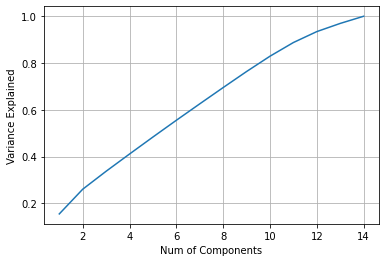

In [67]:
# Построим график изменения variance
explained_variance = []

for n in range(1, 15):
    pca = PCA(n_components=n)
    pca.fit(scaled_X)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    
plt.plot(range(1,15), explained_variance)
plt.grid()
plt.xlabel("Num of Components")
plt.ylabel("Variance Explained");

In [68]:
# Note: В данном наборе PCA не даст выигрыша, приблизило 95% на 13 компонентах из 14. Используем далее обычную разбивку.

# Разделим данные на тестовые и обучающие, с учетом распределения классов:
test_size=0.25     # Размер тестового набора
random_state=21  

# Splitting the dataset into the Training set and Test set, stratify
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=random_state, 
                                                    shuffle=True, 
                                                    stratify=y)

In [69]:
# Data dimensionality and class distribution on train set
print(f"Shape X_train: \n{X_train.shape}\n")
print(f"Class distribution y_train: \n{y_train.value_counts()}")

Shape X_train: 
(442905, 14)

Class distribution y_train: 
0    427408
1     15497
Name: isFraud, dtype: int64


In [70]:
# Data dimensionality and class distribution on test set
print(f"Shape X_test: \n{X_test.shape}\n")
print(f"Class distribution y_test: \n{y_test.value_counts()}")

Shape X_test: 
(147635, 14)

Class distribution y_test: 
0    142469
1      5166
Name: isFraud, dtype: int64


# Building models

## KMeans Model + PCA

### Note: 

Clustering - Unsupervised, non-parametric methods that groups similar data points together based on distance k-Means Randomly place k centroids across normalized data, and assig observations to the nearest centroid. Using the median or medoid (actual data point) may be more robust to noise and outliers. k-modes is used for categorical data. 

k-means++ - improves selection of initial clusters:

1. Pick the ﬁrst center randomly
2. Compute distance between points and the nearest center
3. Choose new center using a weighted probability distribution proportional to distance
4. Repeat until k centers are chosen

Evaluating the number of clusters and performance:
* Silhouette Value - measures how similar a data point is to its own cluster compared to other clusters, and ranges from 1 (best) to -1 (worst).
* Davies-Bouldin Index - ratio of within cluster scatter to between cluster separation, where lower values are better

In [71]:
# Поиск оптимального количества кластеров

Для нахождения оптимального количества числа кластеров можно использовать метод "локтя". Сначала, вычислим сумму квадратов ошибок SSE для диапазона значений k (выберем 2-20). SSE определяется как сумма квадратов расстояния между каждым членом кластера и его центроидом. Далее построим график k --- SSE, (ошибка уменьшается по мере увеличения –k - при увеличении числа кластеров они становятся меньше), выбираем значение -k, при котором SSE резко уменьшается ("эффект локтя").

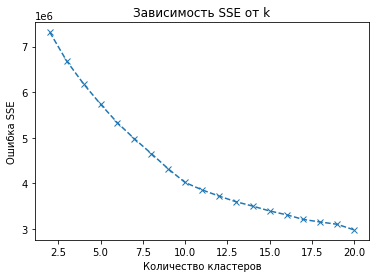

In [72]:
# Массив для хранения ошибок на каждом шаге 
SSE = []

for k in range(2,21):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_X)
    SSE.append(model.inertia_)

# Выведем график зависимости SSE от k
plt.title('Зависимость SSE от k')
plt.xlabel('Количество кластеров')
plt.ylabel('Ошибка SSE')
plt.plot(range(2, 21), SSE, "x--");

Наименьшая ошибка SSD достигается при k равном 11 (первый изгиб), далее можно построить модель с 11 кластерами, которая должна наилучшим образом классифицировать данный набор.
При построений модели на 11 кластеров на данном наборе данных возникнет проблема определения принадлежности каждого кластера к ‘1’ или ‘0’ target переменной и дальнейшей оценки. Построим для данного набора KMeans модель на 2 кластера.

In [73]:
# Создадим модель K-Means clustering с 2 кластерами.
# Create an instance of a K Means model with 2 clusters.
KMeans_model = KMeans(n_clusters=2, random_state=42)

# n_clusters=2 --> Количество кластеров для формирования

# Print Model parameters
print(f"Model parameters: \n{KMeans_model.get_params()}", '\n')

Model parameters: 
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'random_state': 42, 'tol': 0.0001, 'verbose': 0} 



In [74]:
# Fit the model to all the data
KMeans_model.fit(scaled_X)

KMeans(n_clusters=2, random_state=42)

In [75]:
# cluster center vectors
KMeans_model.cluster_centers_

array([[-2.30760677e-01,  1.77382902e+00,  7.50968810e-04,
         1.52263541e-01,  1.55739141e+00,  1.78962395e-02,
        -3.99452811e-01, -2.88509530e-01, -8.88901131e-02,
        -4.30323501e-01, -3.23756343e-01,  1.34759294e+00,
         1.70462250e-01, -4.71796426e-01],
       [ 4.51176501e-02, -3.46813842e-01, -1.46827217e-04,
        -2.97701204e-02, -3.04496595e-01, -3.49902021e-03,
         7.80998408e-02,  5.64085363e-02,  1.73795339e-02,
         8.41355875e-02,  6.32998896e-02, -2.63477415e-01,
        -3.33282786e-02,  9.22442521e-02]])

In [91]:
# Labels of each point
labels_KMeans = KMeans_model.labels_

In [97]:
# Опредиление принадлеждности кластеров / меток относительно целовой переменной isFraud (targets["original"]).
# Так как в данном наборе дисбаланс классов class 0 - 569877(96.5%) и class 1 - 20663(3.5%)
# Distribution of data by class, text
print(pd.DataFrame(KMeans_model.labels_).value_counts(), '\n')

1    493960
0     96580
dtype: int64 



In [98]:
# Переназначим метки кластеров.

# Labels of each point
labels_KMeans = np.choose(KMeans_model.labels_, [1, 0]).astype(np.int64)

# Distribution of data by class, text
print(pd.DataFrame(labels_KMeans).value_counts(), '\n')

0    493960
1     96580
dtype: int64 



In [99]:
# Добавим предсказанные метки в дата фрейм
targets["labels_KMeans"] = labels_KMeans

In [100]:
targets.head(1)

,original,labels_KMeans
0,0,1


In [102]:
# Model Performance

# Accuracy classification score
print("Accuracy classification score: \n", accuracy_score(targets["original"], targets["labels_KMeans"]), '\n')

# ROC Auc Score
print("ROC Auc Score: \n", roc_auc_score(targets["original"], targets["labels_KMeans"]), '\n')

# Build classification report
print("Classification report: \n", classification_report(targets["original"], targets["labels_KMeans"]), '\n')

# Build confusion matrix in text mode
print("Confusion matrix (text mode): \n", confusion_matrix(targets["original"], targets["labels_KMeans"]), '\n')

Accuracy classification score: 
 0.8311325227757645 

ROC Auc Score: 
 0.6349213773319405 

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.85      0.91    569877
           1       0.09      0.42      0.15     20663

    accuracy                           0.83    590540
   macro avg       0.53      0.63      0.53    590540
weighted avg       0.94      0.83      0.88    590540
 

Confusion matrix (text mode): 
 [[482057  87820]
 [ 11903   8760]] 



In [ ]:
# Compute the mean Silhouette Coefficient of all samples.
# silhouette_score(scaled_X, targets["labels_KMeans"]) # Не получается вычислить

In [112]:
# Для возможности визуализации создадим модель PCA() с двумя компонентами.
pca = PCA(n_components=2)
pca.fit(scaled_X)

PCA(n_components=2)

In [113]:
# Сохраним результат в X_pca
X_pca = pca.transform(scaled_X)

In [114]:
# Data dimensionality
print(f"Shape: \n{X_pca.shape}")

Shape: 
(590540, 2)


In [117]:
# Percentage of variance explained by each of the selected components.
print("Percentage of variance: ", pca.explained_variance_ratio_)
print("Sum: ", np.sum(pca.explained_variance_ratio_))

Percentage of variance:  [0.15442113 0.10563519]
Sum:  0.2600563127593396


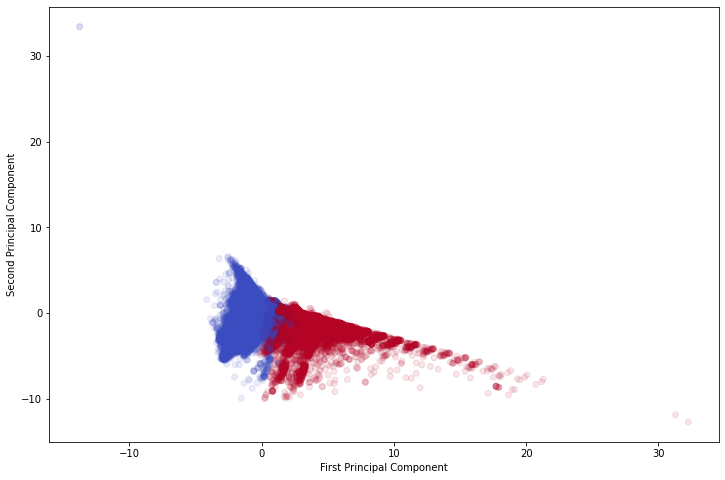

In [119]:
# Визуализация данных при помощи PCA(), с использованием двух компонент.
plt.figure(figsize=(12,8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=targets["labels_KMeans"], cmap="coolwarm", alpha=0.1)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component");

При использований 2-х компонент PCA достоверность данных составляет всего лишь 26%, и не получится отобразить достоверные данные.

## DBSCAN Model

Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm - It is a density-based clustering non-parametric algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away).

In [105]:
# Создадим модель DBSCAN с базовыми настройками.
# Create an instance of a DBSCAN model.
DBSCAN_model = DBSCAN(n_jobs=-1)
# n_jobs=-1 --> The number of parallel jobs to run. -1 all.

# Print Model parameters
print(f"Model parameters: \n{DBSCAN_model.get_params}", '\n')

Model parameters: 
<bound method BaseEstimator.get_params of DBSCAN(n_jobs=-1)> 



In [106]:
# Fit the model to all the data
DBSCAN_model.fit(scaled_X)

DBSCAN(n_jobs=-1)

In [107]:
# Labels of each point
labels_DBSCAN = DBSCAN_model.labels_
labels_DBSCAN

array([ 0,  0, -1, ...,  2,  2,  2], dtype=int64)

In [ ]:
# Добавим предсказанные метки в дата фрейм
targets["labels_DBSCAN"] = labels_DBSCAN

In [109]:
# Distribution of data by class, text
print(targets["labels_DBSCAN"].value_counts(), '\n')

 2       278917
-1       111595
 862      67736
 0        29452
 1        19265
          ...  
 3107         2
 2554         2
 1072         2
 4204         1
 2089         1
Name: labels_DBSCAN, Length: 4843, dtype: int64 



In [275]:
targets["labels_DBSCAN"].unique(), targets["labels_DBSCAN"].nunique()

(array([   0,   -1,    1, ..., 4835, 4838, 4840], dtype=int64), 4843)

В результате получили 4843 кластеров, что показывает не достоверность результатов с базовыми настройками.

In [ ]:
# Создадим модель DBSCAN с eps=1.5, min_samples=15.
# Create an instance of a DBSCAN model.
#DBSCAN_model_2 = DBSCAN(n_jobs=-1, eps=1.5, min_samples=15)
# n_jobs=-1 --> The number of parallel jobs to run. -1 all.

# Print Model parameters
#print(f"Model parameters: \n{DBSCAN_model.get_params}", '\n')

In [ ]:
# Fit the model to all the data
#DBSCAN_model_2.fit(scaled_X)

# Labels of each point
#labels_DBSCAN = DBSCAN_model.labels_
#labels_DBSCAN

# Summary:

В данной работе были использованы методы кластеризации KMeans и DBSCAN. Для метода DBSCAN получилось построить только базовую модель (не получилось поменять гиперпараметры eps и  min_samples вследствие высокой требовательности к аппаратной части). 

Результаты сравнения моделей ниже:

Для KMeans:

* Accuracy classification score: 0.8311 
* ROC Auc Score: 0.6349 
* Accuracy class 1: 0.09

Для базовой логистической регрессий:

* Accuracy classification score: 0.9650
* ROC Auc Score: 0.4999
* Accuracy class 1: 0.00

Для KNeighbors Classifier (n_neighbors =  3):

* Accuracy classification score: 0.9606
* ROC Auc Score: 0.6012
* Accuracy class 1: 0.05

Для XGBClassifier:

* Accuracy classification score: 0.9717
* ROC Auc Score: 0.6201
* Accuracy class 1: 0.83

Данные для логистической регрессий, KNeighbors, XGBClassifier c 10-й работы.

Как видно результаты KMeans лутше чем у базовых моделей логистической регрессий, KNeighbors и значительно хуже чем XGBClassifier. Результаты полученные для DBSCAN в данной работе не являются достоверными. На данном наборе данных лутшие рузультаты XGBClassifier.